In [21]:
import numpy as np
import pandas as pd

In [22]:
df = pd.read_csv("/content/drive/MyDrive/ML-EdgeIIoT-dataset (1).csv", low_memory = False).sample(10000)

In [23]:
df.head()

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
122,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
152743,2021 23:22:28.502174000,131.9.93.129,192.168.0.128,0,0.0,0.0,0,48096.0,6133.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,DDoS_ICMP
97789,2021 18:23:27.908555000,192.168.0.128,192.168.0.170,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,XSS
98963,2021 18:39:15.711583000,192.168.0.128,172.217.19.42,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,XSS
80582,2021 19:36:00.338097000,192.168.0.128,192.168.0.170,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Vulnerability_scanner


In [24]:
df.dropna(axis = 1, inplace = True)
df.shape

(10000, 63)

In [25]:
# Dropping the unnecessary attributes
df.drop(["frame.time", "http.file_data", "http.content_length", "http.request.uri.query",
"http.request.method", "http.referer", "http.request.full_uri",
"http.request.version", "http.response", "http.tls_port", "dns.qry.name", "dns.qry.name.len", "dns.qry.qu",
"dns.qry.type", "dns.retransmission", "dns.retransmit_request",
"dns.retransmit_request_in", "mqtt.conack.flags",
"mqtt.conflag.cleansess", "mqtt.conflags", "mqtt.hdrflags", "mqtt.len",
"mqtt.msg_decoded_as", "mqtt.msg", "mqtt.msgtype", "mqtt.proto_len",
"mqtt.protoname", "mqtt.topic", "mqtt.topic_len", "mqtt.ver","tcp.connection.fin",
"tcp.connection.rst", "tcp.connection.syn", "tcp.connection.synack",
"tcp.dstport", "tcp.flags", "tcp.flags.ack", "tcp.len", "tcp.options",
"tcp.payload", "tcp.seq", "tcp.srcport"
], inplace = True, axis = 1)

In [26]:
df_labels = df[["Attack_label"]]
df_types = df[["Attack_type"]]

In [27]:
# Converting the ip.src_host to int
import ipaddress
def ip_to_int(ip_address):
  try:
    return int(ipaddress.IPv4Address(ip_address))
  except:
    if (ip_address == "0.0") or (ip_address == "0"):
      return 0
    else:
      return np.nan

df["ip.src_host"] = df["ip.src_host"].apply(ip_to_int)
df["arp.dst.proto_ipv4"] = df["arp.dst.proto_ipv4"].apply(ip_to_int)
df["arp.src.proto_ipv4"] = df["arp.src.proto_ipv4"].apply(ip_to_int)
df["ip.dst_host"] = df["ip.dst_host"].apply(ip_to_int)

In [28]:
df.dtypes

,0
ip.src_host,int64
ip.dst_host,int64
arp.dst.proto_ipv4,int64
arp.opcode,float64
arp.hw.size,float64
arp.src.proto_ipv4,int64
icmp.checksum,float64
icmp.seq_le,float64
icmp.transmit_timestamp,float64
icmp.unused,float64


# binary class modelling

* Feature importance

In [29]:
from sklearn.model_selection import train_test_split
X, y = df.drop(["Attack_label", "Attack_type"], axis = 1), df["Attack_label"]
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [30]:
from sklearn.ensemble import RandomForestClassifier
model_bin = RandomForestClassifier(n_estimators = 100, random_state = 42)
model_bin.fit(X_train_bin, y_train_bin)
importance = model_bin.feature_importances_
df_imp_bin = pd.DataFrame({"feature": X_train_bin.columns, "importance": importance})
df_imp_bin.sort_values(by = "importance", ascending = False)

,feature,importance
1,ip.dst_host,0.304479
0,ip.src_host,0.281466
10,tcp.ack,0.247054
12,tcp.checksum,0.067050
11,tcp.ack_raw,0.064721
14,udp.stream,0.015002
6,icmp.checksum,0.009430
7,icmp.seq_le,0.009077
5,arp.src.proto_ipv4,0.000614
2,arp.dst.proto_ipv4,0.000463


In [43]:
df_imp_bin = df_imp_bin[df_imp_bin["importance"] > 0.0001]
imp_bin_cols = [col for col in np.array(df_imp_bin["feature"])]
imp_bin_cols

KeyError: 'importance'

In [32]:
df_imp_bin = df[imp_bin_cols]
df_imp_bin = pd.merge(df_imp_bin, df_labels, left_index = True, right_index = True)
df_imp_bin.dropna(axis = 1, inplace = True)
df_imp_bin

,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,tcp.ack,tcp.ack_raw,tcp.checksum,udp.port,udp.stream,udp.time_delta,Attack_label
122,0,0,0,0.0,0,0.0,0.0,0.0,0.000000e+00,0.0,22.0,0.0,12.0,1
152743,2198429057,3232235648,0,0.0,0,48096.0,6133.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,1
97789,3232235648,3232235690,0,0.0,0,0.0,0.0,1.0,4.018446e+08,7305.0,0.0,0.0,0.0,1
98963,3232235648,2899907370,0,0.0,0,0.0,0.0,1834.0,4.963123e+08,36358.0,0.0,0.0,0.0,1
80582,3232235648,3232235690,0,0.0,0,0.0,0.0,2283.0,1.548690e+09,32437.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56518,3232235648,3232235690,0,0.0,0,0.0,0.0,261.0,1.778809e+09,52537.0,0.0,0.0,0.0,1
155626,3232235648,1336950319,0,0.0,0,62312.0,36805.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,1
89958,3232235690,3232235648,0,0.0,0,0.0,0.0,403489.0,2.692459e+09,52241.0,0.0,0.0,0.0,1
134781,3232235648,0,0,0.0,0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1105585.0,0.0,1


In [33]:
X, y = df_imp_bin.drop("Attack_label", axis = 1), df_imp_bin["Attack_label"]
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [34]:
# oversample the data for most accuracy
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy = "minority")
X_resampled_bin, y_resampled_bin = ros.fit_resample(X_train_bin, y_train_bin)

<Axes: ylabel='count'>

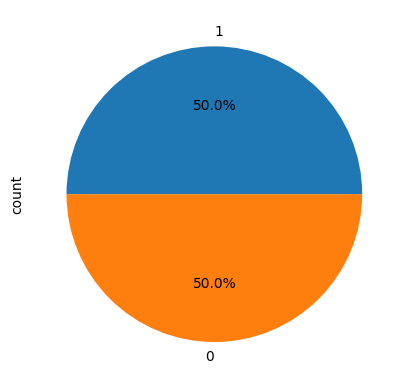

In [35]:
y_resampled_bin.value_counts().plot.pie(autopct = "%0.1f%%")

from our previous observations we seen that knn, svc, logistic_reg are candidates to apply bagging

In [39]:
# apply the bagging

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

bagging_knn = BaggingClassifier(KNeighborsClassifier(n_neighbors = 5), n_estimators = 50, max_samples = 0.8, bootstrap = True)
bagging_svc = BaggingClassifier(SVC(C = 0.1, kernel = "sigmoid", max_iter = 10000), n_estimators = 10, max_samples = 0.8, bootstrap = True)
bagging_lr = BaggingClassifier(LogisticRegression(C = 0.1, max_iter = 10000), n_estimators = 50, max_samples = 0.8, bootstrap = True)
bagging_rf = BaggingClassifier(RandomForestClassifier(n_estimators = 100, random_state = 42), n_estimators = 50, max_samples = 0.8, bootstrap = True)
bagging_nb = BaggingClassifier(GaussianNB(), n_estimators = 50, max_samples = 0.8, bootstrap = True)

models = []
models.append((bagging_knn, "KNN"))
models.append((bagging_svc, "SVC"))
models.append((bagging_lr, "LR"))
models.append((bagging_rf, "RF"))
models.append((bagging_nb, "NB"))

print("Do you want to print classification_report(0, 1): ")
choice = int(input())
for bagger, name in models:
  print("training: ", name)
  bagger.fit(X_resampled_bin, y_resampled_bin)
  print(name, bagger.score(X_test_bin, y_test_bin))
  if choice == 1:
    print(classification_report(y_test_bin, bagger.predict(X_test_bin)))
  print("-" * 40)

Do you want to print classification_report(0, 1): 
1
training:  KNN
KNN 0.7153333333333334
              precision    recall  f1-score   support

           0       0.29      0.67      0.41       437
           1       0.93      0.72      0.81      2563

    accuracy                           0.72      3000
   macro avg       0.61      0.69      0.61      3000
weighted avg       0.83      0.72      0.75      3000

----------------------------------------
training:  SVC


KeyboardInterrupt: 

# Multiclass modelling

* Feature importance

In [40]:
from sklearn.model_selection import train_test_split
X, y = df.drop(["Attack_label", "Attack_type"], axis = 1), df["Attack_type"]
X_train_type, X_test_type, y_train_type, y_test_type = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [42]:
from sklearn.ensemble import RandomForestClassifier
model_type = RandomForestClassifier(n_estimators = 100, random_state = 42)
model_type.fit(X_train_type, y_train_type)
importance = model_type.feature_importances_
df_imp_type = pd.DataFrame({"feature": X_train_type.columns, "importance": importance})
df_imp_type.sort_values(by = "importance", ascending = False)

,feature,importance
10,tcp.ack,0.281865
11,tcp.ack_raw,0.196731
12,tcp.checksum,0.172015
1,ip.dst_host,0.104456
0,ip.src_host,0.097806
14,udp.stream,0.060749
6,icmp.checksum,0.038735
7,icmp.seq_le,0.035725
2,arp.dst.proto_ipv4,0.003584
3,arp.opcode,0.002938


In [45]:
df_imp_type = df_imp_type[df_imp_type["importance"] > 0.0001]
imp_type_cols = [col for col in np.array(df_imp_type["feature"])]
imp_type_cols

['ip.src_host',
 'ip.dst_host',
 'arp.dst.proto_ipv4',
 'arp.opcode',
 'arp.hw.size',
 'arp.src.proto_ipv4',
 'icmp.checksum',
 'icmp.seq_le',
 'icmp.transmit_timestamp',
 'tcp.ack',
 'tcp.ack_raw',
 'tcp.checksum',
 'udp.port',
 'udp.stream',
 'udp.time_delta']

In [49]:
df_imp_type = df[imp_type_cols]
df_imp_type = pd.merge(df_imp_type, df_types, left_index = True, right_index = True)
df_imp_type.dropna(axis = 1, inplace = True)
df_imp_type

,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,tcp.ack,tcp.ack_raw,tcp.checksum,udp.port,udp.stream,udp.time_delta,Attack_type
122,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,22.0,0.0,12.0,MITM
152743,2198429057,3232235648,0,0.0,0.0,0,48096.0,6133.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,DDoS_ICMP
97789,3232235648,3232235690,0,0.0,0.0,0,0.0,0.0,0.0,1.0,4.018446e+08,7305.0,0.0,0.0,0.0,XSS
98963,3232235648,2899907370,0,0.0,0.0,0,0.0,0.0,0.0,1834.0,4.963123e+08,36358.0,0.0,0.0,0.0,XSS
80582,3232235648,3232235690,0,0.0,0.0,0,0.0,0.0,0.0,2283.0,1.548690e+09,32437.0,0.0,0.0,0.0,Vulnerability_scanner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56518,3232235648,3232235690,0,0.0,0.0,0,0.0,0.0,0.0,261.0,1.778809e+09,52537.0,0.0,0.0,0.0,Password
155626,3232235648,1336950319,0,0.0,0.0,0,62312.0,36805.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,DDoS_ICMP
89958,3232235690,3232235648,0,0.0,0.0,0,0.0,0.0,0.0,403489.0,2.692459e+09,52241.0,0.0,0.0,0.0,Backdoor
134781,3232235648,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1105585.0,0.0,DDoS_UDP


oversampling

In [54]:
# oversample the data for most accuracy
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy = "minority")
X_resampled_type, y_resampled_type = ros.fit_resample(X_train_type, y_train_type)

In [55]:
X, y = df_imp_type.drop("Attack_type", axis = 1), df_imp_type["Attack_type"]
X_train_type, X_test_type, y_train_type, y_test_type = train_test_split(X, y, test_size = 0.3, random_state = 42)

<Axes: ylabel='count'>

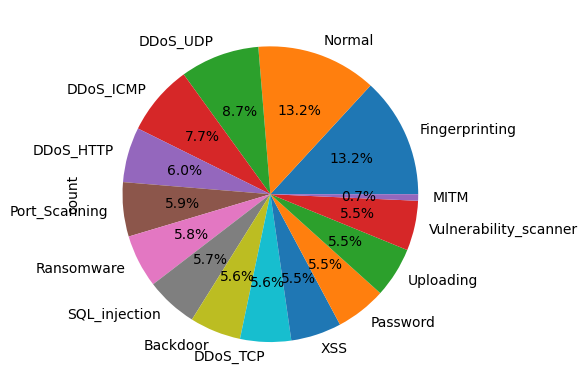

In [56]:
y_resampled_type.value_counts().plot.pie(autopct = "%0.1f%%")

In [ ]:
# apply the bagging

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

bagging_knn = BaggingClassifier(KNeighborsClassifier(n_neighbors = 5), n_estimators = 50, max_samples = 0.8, bootstrap = True)
bagging_svc = BaggingClassifier(SVC(C = 0.1, kernel = "sigmoid", max_iter = 10000), n_estimators = 50, max_samples = 0.8, bootstrap = True)
bagging_lr = BaggingClassifier(LogisticRegression(C = 0.1, max_iter = 10000), n_estimators = 50, max_samples = 0.8, bootstrap = True)
bagging_rf = BaggingClassifier(RandomForestClassifier(n_estimators = 100, random_state = 42), n_estimators = 50, max_samples = 0.8, bootstrap = True)
bagging_nb = BaggingClassifier(GaussianNB(), n_estimators = 50, max_samples = 0.8, bootstrap = True)

models = []
models.append((bagging_knn, "KNN"))
models.append((bagging_svc, "SVC"))
models.append((bagging_lr, "LR"))
models.append((bagging_rf, "RF"))
models.append((bagging_nb, "NB"))

print("Do you want to print classification_report(0, 1): ")
choice = int(input())
for bagger, name in models:
  print("training: ", name)
  bagger.fit(X_resampled_bin, y_resampled_bin)
  print(name, bagger.score(X_test_bin, y_test_bin))
  if choice == 1:
    print(classification_report(y_test_bin, bagger.predict(X_test_bin)))
  print("-" * 40)

Do you want to print classification_report(0, 1): 
1
training:  KNN
KNN 0.714
              precision    recall  f1-score   support

           0       0.29      0.68      0.41       437
           1       0.93      0.72      0.81      2563

    accuracy                           0.71      3000
   macro avg       0.61      0.70      0.61      3000
weighted avg       0.84      0.71      0.75      3000

----------------------------------------
training:  SVC
